In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import datetime

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')


In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving AAL.csv to AAL.csv


In [5]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['AAL.csv']))
len(df)

4333

In [6]:
df = df.copy()
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,27-09-2005,19.100000,21.049999,961200,21.400000,19.299999,18.194910
1,28-09-2005,19.200001,19.299999,5747900,20.530001,20.500000,19.326204
2,29-09-2005,20.100000,20.400000,1078200,20.580000,20.209999,19.052805
3,30-09-2005,20.180000,20.260000,3123300,21.049999,21.010000,19.807001
4,03-10-2005,20.900000,20.900000,1057900,21.750000,21.500000,20.268940


In [7]:
df.tail()

,Date,Low,Open,Volume,High,Close,Adjusted Close
4328,06-12-2022,14.00,14.14,20781500,14.34,14.330,14.330
4329,07-12-2022,13.53,14.24,28161400,14.24,13.550,13.550
4330,08-12-2022,13.38,13.65,25300900,13.80,13.600,13.600
4331,09-12-2022,13.42,13.52,18489800,13.66,13.530,13.530
4332,12-12-2022,13.45,13.49,8048550,13.93,13.915,13.915


In [8]:
df.dtypes

Date               object
Low               float64
Open              float64
Volume              int64
High              float64
Close             float64
Adjusted Close    float64
dtype: object

In [9]:
# convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
# group data by month, count unique days per month
days_per_month = df.groupby(df['Date'].dt.to_period('M'))['Date'].nunique()

# convert series to dataframe
days_per_month = pd.DataFrame(days_per_month)
days_per_month.head(30)

,Date
Date,
2005-09,4
2005-10,21
2005-11,21
2005-12,21
2006-01,20
2006-02,19
2006-03,23
2006-04,19
2006-05,22


In [11]:
# remove rows with year 2005 : least working days
df = df[df['Date'].dt.year != 2005]

# reset df
df.reset_index(inplace = True, drop = True)

df.head(10)

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,2006-01-03,36.849998,37.200001,1013200,38.279999,37.450001,35.305672
1,2006-01-04,37.700001,37.700001,1928400,40.599998,39.200001,36.955467
2,2006-01-05,38.910000,39.180000,317900,39.709999,39.709999,37.436268
3,2006-01-06,38.139999,39.709999,349200,39.709999,39.000000,36.766914
4,2006-01-09,38.500000,38.799999,220800,38.880001,38.610001,36.399242
5,2006-01-10,37.400002,38.610001,191300,38.709999,37.799999,35.635628
6,2006-01-11,34.650002,37.799999,974300,37.799999,34.799999,32.807415
7,2006-01-12,32.959999,33.000000,2008900,35.349998,34.990002,32.986526
8,2006-01-13,33.310001,35.000000,734200,35.419998,34.049999,32.100342
9,2006-01-17,29.620001,33.549999,2351200,33.549999,30.000000,28.282244


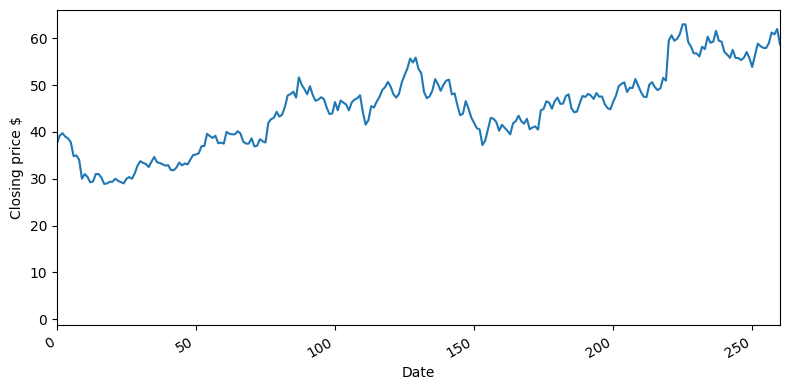

In [12]:
# plot first year of target

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price $')
ax.set_xlim(0, 260)

fig.autofmt_xdate()
plt.tight_layout()


In [13]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [14]:
# save cleaned data to csv
df.to_csv('aalcleandata.csv')
!cp aalcleandata.csv "drive/My Drive/"

In [15]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [16]:
import pandas as pd
pd.read_csv("/content/drive/MyDrive/aalcleandata.csv")

,Unnamed: 0,Date,Low,Open,Volume,High,Close,Adjusted Close
0,0,2006-01-03,36.849998,37.200001,1013200,38.279999,37.450001,35.305672
1,1,2006-01-04,37.700001,37.700001,1928400,40.599998,39.200001,36.955467
2,2,2006-01-05,38.910000,39.180000,317900,39.709999,39.709999,37.436268
3,3,2006-01-06,38.139999,39.709999,349200,39.709999,39.000000,36.766914
4,4,2006-01-09,38.500000,38.799999,220800,38.880001,38.610001,36.399242
...,...,...,...,...,...,...,...,...
4261,4261,2022-12-06,14.000000,14.140000,20781500,14.340000,14.330000,14.330000
4262,4262,2022-12-07,13.530000,14.240000,28161400,14.240000,13.550000,13.550000
4263,4263,2022-12-08,13.380000,13.650000,25300900,13.800000,13.600000,13.600000
4264,4264,2022-12-09,13.420000,13.520000,18489800,13.660000,13.530000,13.530000


In [17]:
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,2006-01-03,36.849998,37.200001,1013200,38.279999,37.450001,35.305672
1,2006-01-04,37.700001,37.700001,1928400,40.599998,39.200001,36.955467
2,2006-01-05,38.910000,39.180000,317900,39.709999,39.709999,37.436268
3,2006-01-06,38.139999,39.709999,349200,39.709999,39.000000,36.766914
4,2006-01-09,38.500000,38.799999,220800,38.880001,38.610001,36.399242


In [18]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4266,2014-06-23 15:07:40.759493632,2006-01-03 00:00:00,2010-03-30 06:00:00,2014-06-24 12:00:00,2018-09-17 18:00:00,2022-12-12 00:00:00,NaN
Low,4266.0,24.887229,1.45,10.535,21.335,39.139999,62.0,15.807891
Open,4266.0,25.38824,1.81,10.8225,21.89,39.745,62.700001,16.006334
Volume,4266.0,14589389.744491,191300.0,4749500.0,7557550.0,13528325.0,428617100.0,22074557.816849
High,4266.0,25.854116,2.03,11.1125,22.240001,40.2975,63.27,16.193664
Close,4266.0,25.356729,1.76,10.7925,21.815,39.704999,62.950001,16.004301
Adjusted Close,4266.0,24.399546,1.659225,10.241128,21.435,37.975982,59.345573,15.334426


In [19]:
df['Date'] = pd.to_datetime(df['Date'])

# get month and year from 'date' column
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# find mean close price per month
mean_per_mth = df.groupby([ 'Month'])['Close'].mean().reset_index()

# mean close price per year
mean_per_year = df.groupby([ 'Year'])['Close'].mean().reset_index()

In [20]:
mean_per_mth

,Month,Close
0,1,27.501545
1,2,27.312301
2,3,26.263324
3,4,25.501880
4,5,25.268106
5,6,24.701071
6,7,24.789972
7,8,23.683342
8,9,23.654870
9,10,24.397701


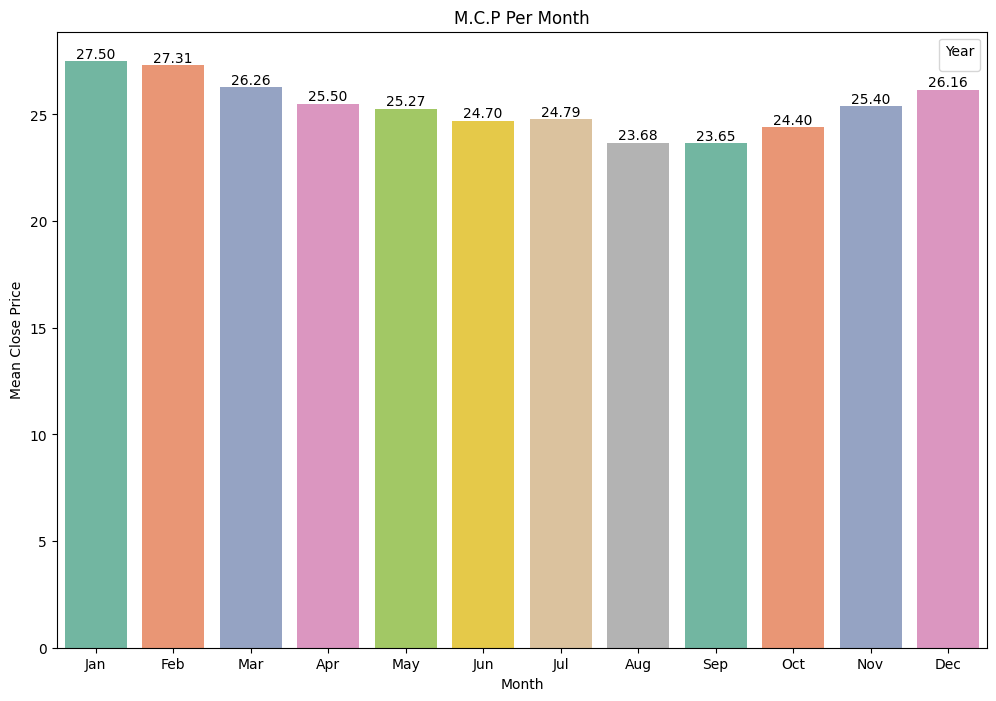

In [21]:
# plot mean close price
ax = sns.barplot(data=mean_per_mth, x='Month', y='Close', palette='Set2')

plt.title('M.C.P Per Month')
plt.xlabel('Month')
plt.ylabel('Mean Close Price')

plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')

for g in ax.containers:
  ax.bar_label(g, fontsize=10, fmt='%.2f')
plt.show()

In [22]:
mean_per_year.head()

,Year,Close
0,2006,44.322390
1,2007,35.671952
2,2008,7.742134
3,2009,3.829643
4,2010,8.636667


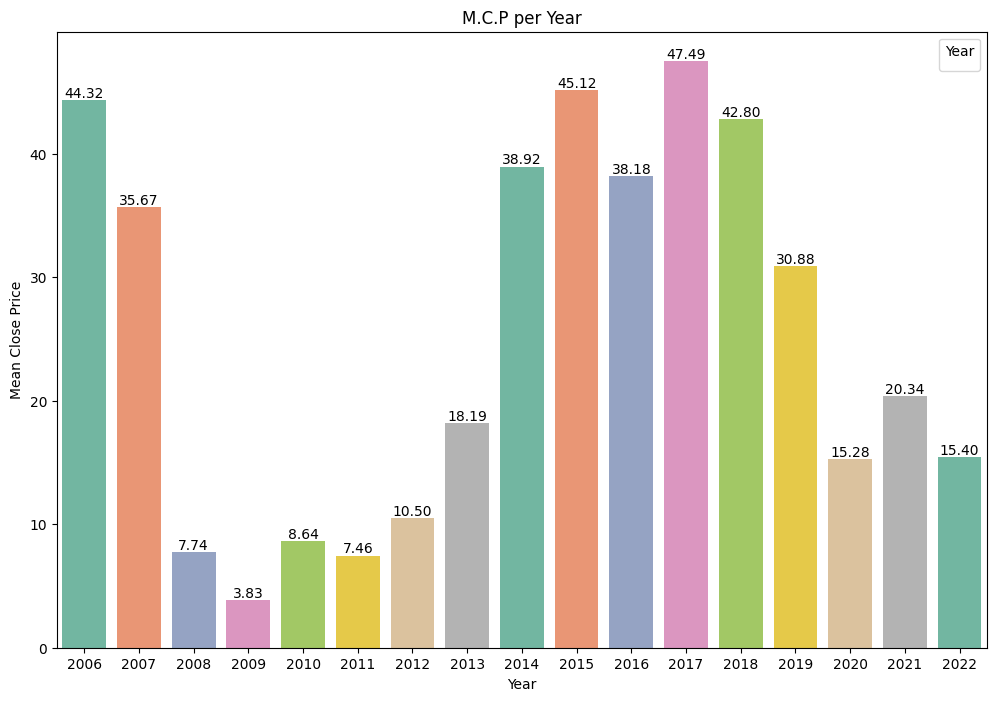

In [23]:
t_year = mean_per_year['Year'].tolist()
# mean close price per month
ax = sns.barplot(data=mean_per_year, x='Year', y='Close',  palette='Set2')
plt.title('M.C.P per Year')
plt.xlabel('Year')
plt.ylabel('Mean Close Price')
plt.xticks(range(0, len(t_year)), labels=t_year)
plt.legend(title='Year')

for g in ax.containers:
  ax.bar_label(g, fontsize=10, fmt='%.2f')

plt.show()

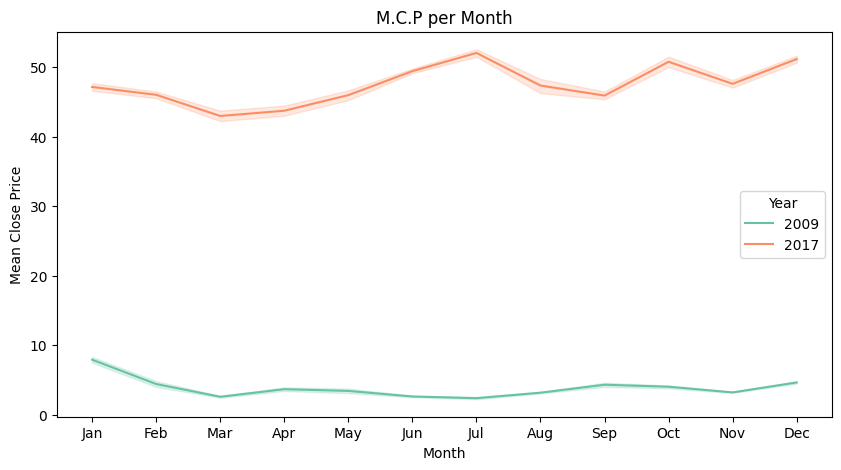

In [24]:
# mean close price per month
plt.figure(figsize=(10, 5))
compare_df = df[df['Year'].isin([2009,2017])]
sns.lineplot(data=compare_df, x='Month', y='Close', hue='Year', palette='Set2')
plt.title('M.C.P per Month')
plt.xlabel('Month')
plt.ylabel('Mean Close Price')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.show()

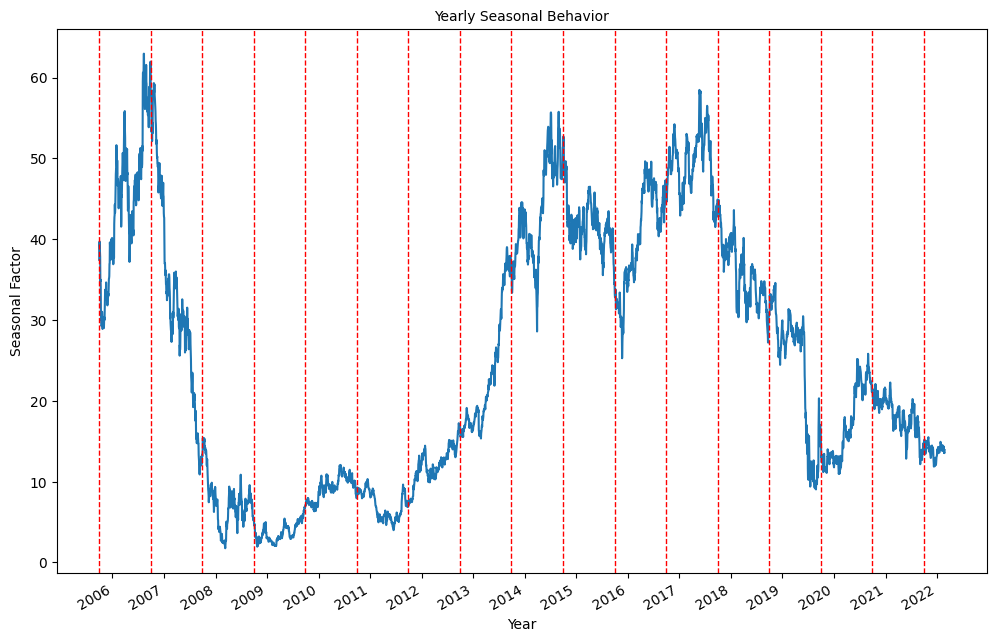

<Figure size 1000x500 with 0 Axes>

In [25]:
#yearly cyclic behavior

fig, ax = plt.subplots()

ax.plot(df['Close'])
for i in np.arange(0, len(df), 260):
  ax.axvline(x=i, linestyle='--', color='red', linewidth=1)

plt.title('Yearly Seasonal Behavior', fontsize = 10)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Seasonal Factor', fontsize = 10)
plt.xticks(np.arange(67, len(df), 260), np.arange(2006, 2023, 1))
plt.figure(figsize=(10, 5))
fig.autofmt_xdate()
plt.tight_layout()

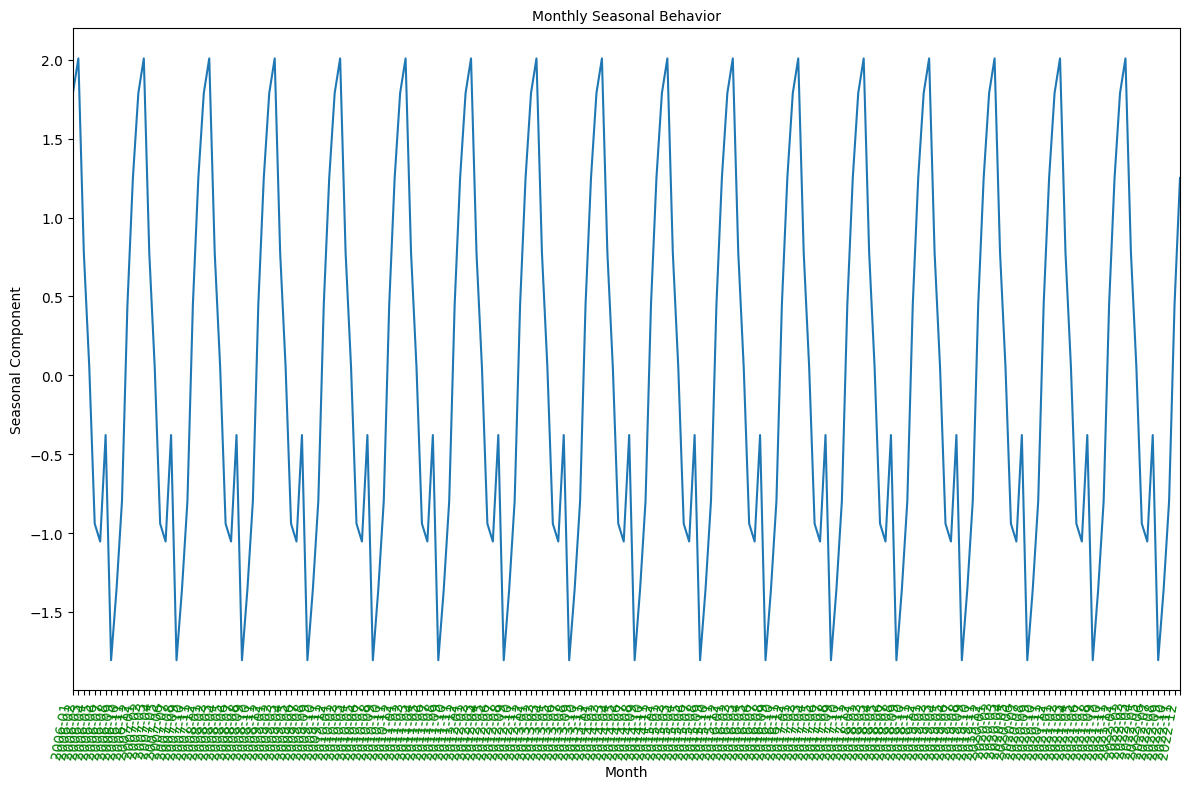

In [26]:
import statsmodels.api as sm
df_seasons = df.copy()

# date column = index
df_seasons.set_index('Date', inplace=True)

# resample data to monthly
monthly_data = df_seasons['Close'].resample('M').mean()

# get month numbers for xticks
monthly_no = pd.to_datetime(monthly_data.index).strftime('%m')

df_months = monthly_data.to_frame(name='Close')
df_months['monthly_no'] = monthly_no

decomposition = sm.tsa.seasonal_decompose(monthly_data, model='additive')

#plot
fig, ax = plt.subplots()
decomposition.seasonal.plot(ax=ax)

times = np.arange('2006-01', '2023-01', dtype='datetime64[M]')
ax.set_xticks(times)

for n in np.arange(0, len(df), 1):
  ax.axvline(x=i, linestyle='--', color='orange', linewidth=1)

plt.title('Monthly Seasonal Behavior' ,  fontsize = 10)
plt.xlabel('Month',  fontsize = 10)
plt.ylabel('Seasonal Component',fontsize = 10)

plt.rcParams['figure.figsize'] = (30, 10)

fig.autofmt_xdate()
ax.set_xticklabels(times, rotation = 80, ha = 'right', fontsize = 10, color = 'green')

plt.tight_layout()
plt.show()
# see monthly repeated patterns --> seasonal behavior in data

In [27]:
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close,Month,Year
0,2006-01-03,36.849998,37.200001,1013200,38.279999,37.450001,35.305672,1,2006
1,2006-01-04,37.700001,37.700001,1928400,40.599998,39.200001,36.955467,1,2006
2,2006-01-05,38.910000,39.180000,317900,39.709999,39.709999,37.436268,1,2006
3,2006-01-06,38.139999,39.709999,349200,39.709999,39.000000,36.766914,1,2006
4,2006-01-09,38.500000,38.799999,220800,38.880001,38.610001,36.399242,1,2006


In [28]:
# remove
drop_col = ['Date']
df = df.drop(drop_col, axis=1)
df.head()

,Low,Open,Volume,High,Close,Adjusted Close,Month,Year
0,36.849998,37.200001,1013200,38.279999,37.450001,35.305672,1,2006
1,37.700001,37.700001,1928400,40.599998,39.200001,36.955467,1,2006
2,38.910000,39.180000,317900,39.709999,39.709999,37.436268,1,2006
3,38.139999,39.709999,349200,39.709999,39.000000,36.766914,1,2006
4,38.500000,38.799999,220800,38.880001,38.610001,36.399242,1,2006


In [29]:
# split
n = len(df)

# 70/20/10 (train/val/test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [31]:
# save for modeling
train_df.to_csv('aaltrain.csv', index=False, header=True)
val_df.to_csv('aalval.csv', index=False, header=True)
test_df.to_csv('aaltest.csv', index=False, header=True)
!cp aaltrain.csv "drive/My Drive/"
!cp aalval.csv "drive/My Drive/"
!cp aaltest.csv "drive/My Drive/"

In [32]:
# predict close price in next 21 working days using univariate multistep model
train_df = pd.read_csv('aaltrain.csv')
val_df = pd.read_csv('aalval.csv')
test_df = pd.read_csv('aaltest.csv')

In [33]:
# dict: store column names
column_index = {name: i for i, name in enumerate(train_df.columns)}

In [34]:
class DataWindow():

  def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

            self.train_df = train_df
            self.val_df = val_df
            self.test_df = test_df

            # column to predict
            self.label_columns = label_columns
            if label_columns is not None:
                # dict with the name and index of the label column.
                # for plot
                self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            # dict with the name and index of each column
            # to separate features from target
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

            self.input_width = input_width
            self.label_width = label_width
            self.shift = shift

            self.total_window_size = input_width + shift

            # slice a sequence.
            # input slice starts at 0 and ends at input_width.
            self.input_slice = slice(0, input_width)
            # assign indices to the inputs : for plotting.
            self.input_indices = np.arange(self.total_window_size)[self.input_slice]


            # get index at which the label starts
            # ...the total window size minus the width of the label.
            self.label_start = self.total_window_size - self.label_width
            # same steps applied for the inputs are applied for labels.
            self.labels_slice = slice(self.label_start, None)
            self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_to_inputs_labels(self, features):
            #Slice the window for inputs with the input_slice defined in __init__.
            inputs = features[:, self.input_slice, :]
            #Slice the window for labels using the labels_slice defined in __init__
            labels = features[:, self.labels_slice, :]

            # stack the label if more than 1 target
            if self.label_columns is not None:
                labels = tf.stack(
                    [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                    axis=-1
                )
            # Shape = [batch, time, features]
            inputs.set_shape([None, self.input_width, None])
            labels.set_shape([None, self.label_width, None])

            return inputs, labels

  def plot(self, model=None, plot_col='Close', max_subplots=3):
            inputs, labels = self.sample_batch

            plt.figure(figsize=(12, 8))
            plot_col_index = self.column_indices[plot_col]
            max_n = min(max_subplots, len(inputs))

            #Plot inputs : showing blue line with dots.
            for n in range(max_n):
                plt.subplot(3, 1, n+1)
                plt.ylabel(f'{plot_col} [scaled]')
                plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                        label='Inputs', marker='.', zorder=-10)

                if self.label_columns:
                  label_col_index = self.label_columns_indices.get(plot_col, None)
                else:
                  label_col_index = plot_col_index

                if label_col_index is None:
                  continue

                #Plot labels or actual: showing orange squares.
                plt.scatter(self.label_indices, labels[n, :, label_col_index],
                            edgecolors='k', marker='s', label='Labels', c='orange', s=64)
                if model is not None:
                  predictions = model(inputs)
                  #Plot predictions: showing green crosses.
                  plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='green', s=64)

                if n == 0:
                  plt.legend()

            plt.xlabel('Date (Day)')
            plt.ylabel('Closing price (USD)')

  def make_dataset(self, data):
            data = np.array(data, dtype=np.float32)
            ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                #Pass in data: training set, validation set, or test set.
                data=data,
                #Targets: split_to_input_labels function = None
                targets=None,
                #Define the total length of s the array: the total window length.
                sequence_length=self.total_window_size,
                #Define the number of timesteps separating each sequence: consecutive sequences, so sequence_stride=1.
                sequence_stride=1,
                #Shuffle the sequences: data is still in chronological order, just shuffling the order of the sequences, which makes the model more robus
                shuffle=True,
                #Number of sequences
                batch_size=32
            )

            ds = ds.map(self.split_to_inputs_labels)
            return ds

  @property
  def train(self):
      return self.make_dataset(self.train_df)

  @property
  def val(self):
      return self.make_dataset(self.val_df)

  @property
  def test(self):
      return self.make_dataset(self.test_df)

  @property
  def sample_batch(self):
    # sample batch of data for plot. If sample batch does not exist, we’ll retrieve a sample batch and cache it
      result = getattr(self, '_sample_batch', None)
      if result is None:
          result = next(iter(self.train))
          self._sample_batch = result
      return result


In [35]:
# max_epochs: set max epochs
def compile_and_fit(model, window, patience=3, max_epochs=50):
      early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

      # mse : loss function , MAE : evaluation metric --> compare the performance of our models
      model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

      # fit model on training set
      history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

      return history

In [36]:
# baseline models required for all forecasting : repeats last day and value, and repeats last month of data

In [37]:
multi_window = DataWindow(input_width=21, label_width=21, shift=21, label_columns=['Close'])

In [38]:
# baseline: repeat last day and value (final)
class MultiStepLastBaseline(Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return tf.tile(inputs[:, -1:, :], [1, 21, 1])
    return tf.tile(inputs[:, -1:, self.label_index:], [1, 21, 1])

In [39]:
baseline_final = MultiStepLastBaseline(label_index=column_index['Close'])
baseline_final.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
val_performance = {}
performance = {}
val_performance['Baseline - Last'] = baseline_final.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_final.evaluate(multi_window.test, verbose=0)


26/26 [==============================] - 1s 5ms/step - loss: 0.2019 - mean_absolute_error: 0.2921


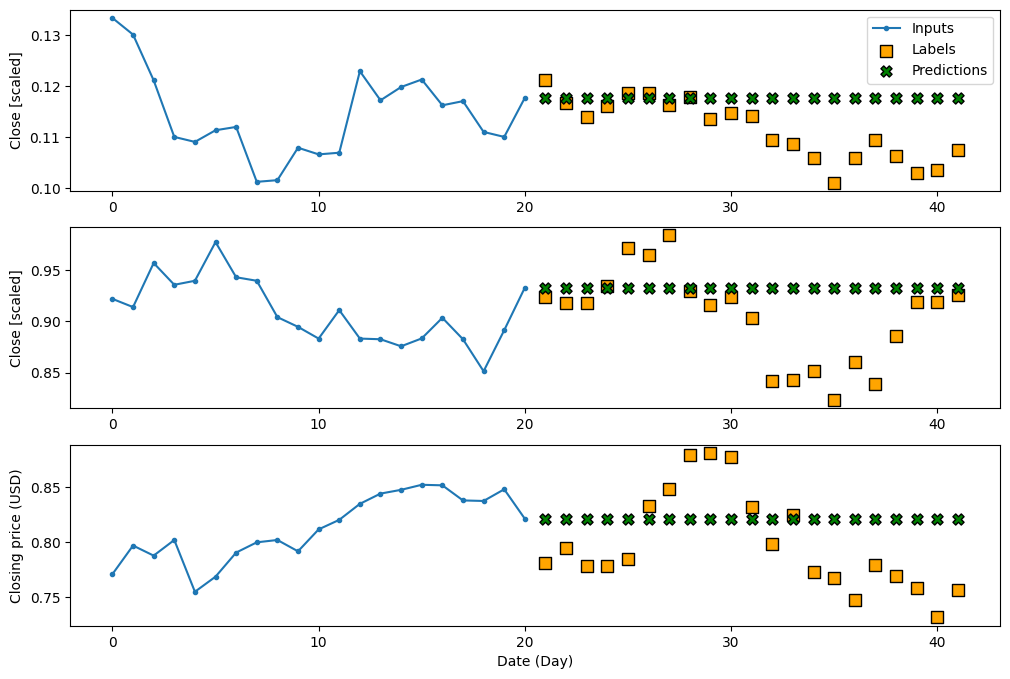

In [40]:
# plot predictions
multi_window.plot(baseline_final)

In [41]:
#repeat : last day, prediction will be last 21 days

class RepeatBaseline(Model):
  def __init__(self, label_index = None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    return inputs[:, :, self.label_index:]

In [44]:
# make predictions, compare baseline performance

repeat_baseline = RepeatBaseline(label_index=column_index['Close'])
repeat_baseline.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
val_performance['Baseline-Repeat'] = repeat_baseline.evaluate(multi_window.val)
performance['Baseline-Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

26/26 [==============================] - 1s 3ms/step - loss: 0.2003 - mean_absolute_error: 0.2977


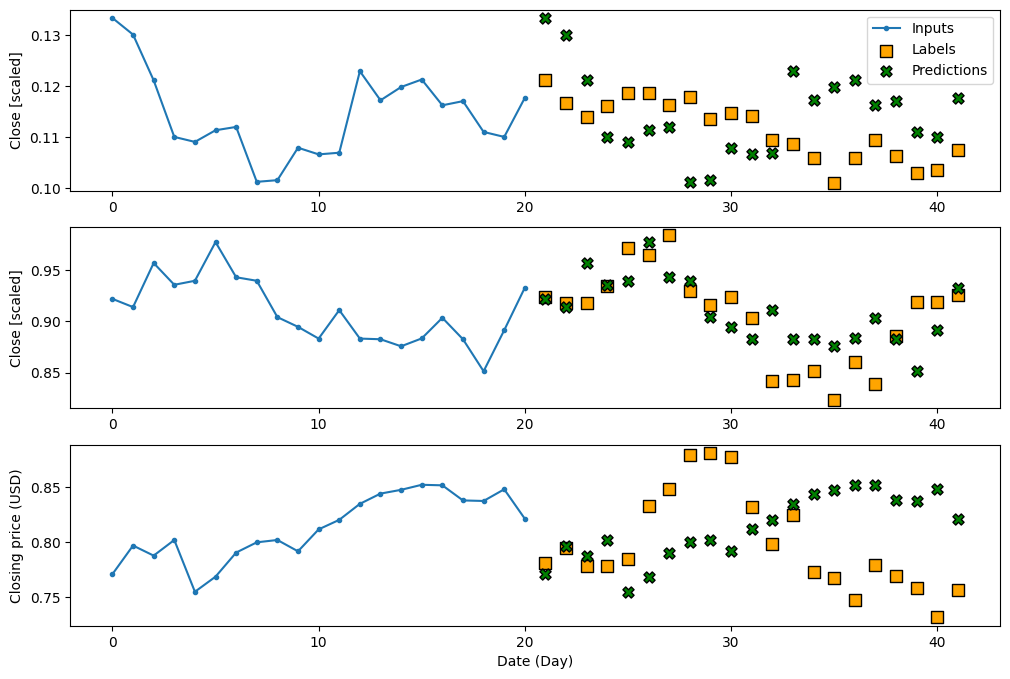

In [47]:
multi_window.plot(repeat_baseline)

In [50]:
# build linear model: input and output layer

label_index = column_index['Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer = tf.initializers.zeros)
])

In [52]:
history = compile_and_fit(linear, multi_window)
val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 2s 13ms/step - loss: 0.0034 - mean_absolute_error: 0.0427 - val_loss: 0.0075 - val_mean_absolute_error: 0.0674
Epoch 2/50
93/93 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_absolute_error: 0.0426 - val_loss: 0.0071 - val_mean_absolute_error: 0.0654
Epoch 3/50
93/93 [==============================] - 1s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0426 - val_loss: 0.0069 - val_mean_absolute_error: 0.0644
Epoch 4/50
93/93 [==============================] - 0s 5ms/step - loss: 0.0034 - mean_absolute_error: 0.0425 - val_loss: 0.0077 - val_mean_absolute_error: 0.0679
Epoch 5/50
93/93 [==============================] - 1s 5ms/step - loss: 0.0034 - mean_absolute_error: 0.0426 - val_loss: 0.0078 - val_mean_absolute_error: 0.0686
Epoch 6/50
26/26 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_error: 0.0708


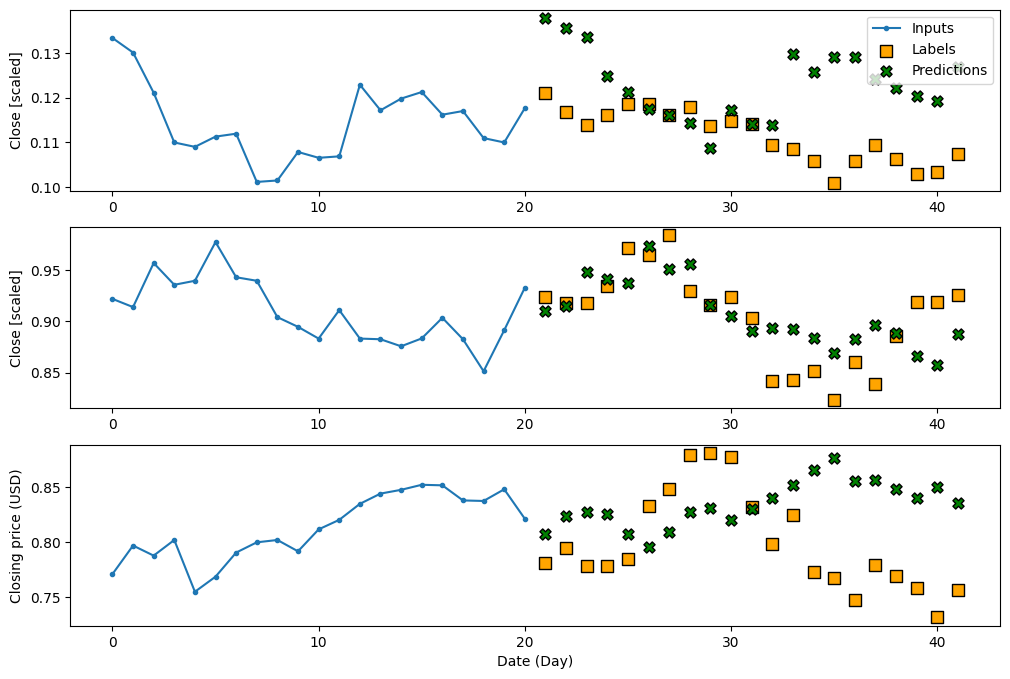

In [53]:
multi_window.plot(linear)

In [54]:
# 2 dense layers: 64 neurons and ReLU

dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)
val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 3s 10ms/step - loss: 0.0434 - mean_absolute_error: 0.1330 - val_loss: 0.0061 - val_mean_absolute_error: 0.0582
Epoch 2/50
93/93 [==============================] - 1s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0432 - val_loss: 0.0062 - val_mean_absolute_error: 0.0598
Epoch 3/50
93/93 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_absolute_error: 0.0410 - val_loss: 0.0070 - val_mean_absolute_error: 0.0658
Epoch 4/50
26/26 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_error: 0.0711


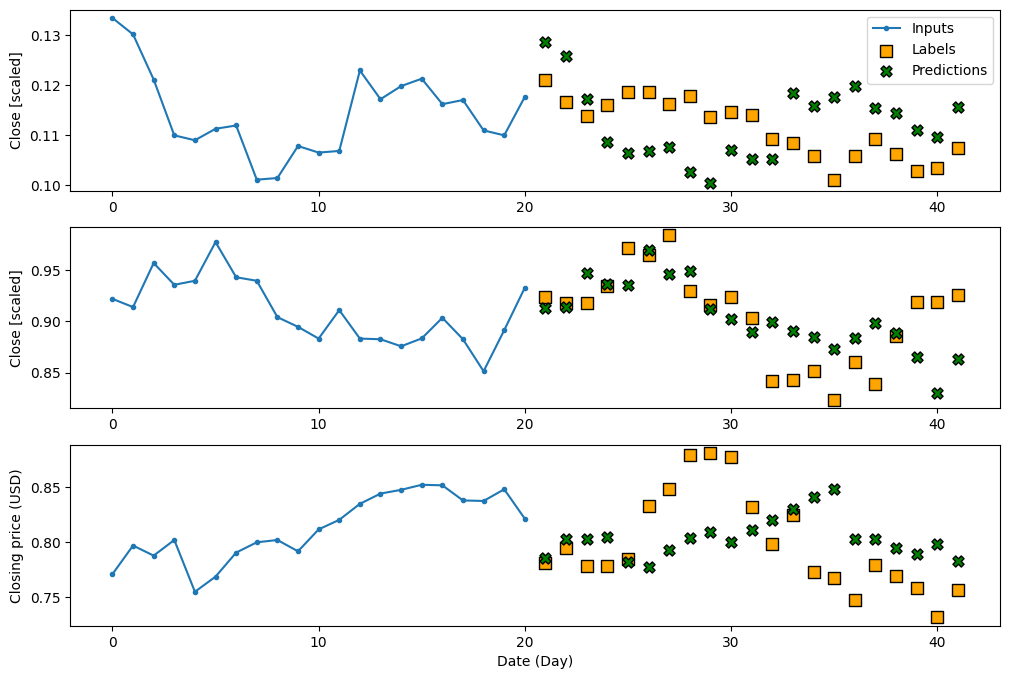

In [55]:
multi_window.plot(dense)

In [57]:
# LSTM : input sequence through LSTM layer

lstm = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm, multi_window)

val_performance['LSTM'] = lstm.evaluate(multi_window.val)
performance['LSTM'] = lstm.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 5s 19ms/step - loss: 0.0620 - mean_absolute_error: 0.1634 - val_loss: 0.0154 - val_mean_absolute_error: 0.0888
Epoch 2/50
93/93 [==============================] - 1s 16ms/step - loss: 0.0097 - mean_absolute_error: 0.0620 - val_loss: 0.0096 - val_mean_absolute_error: 0.0715
Epoch 3/50
93/93 [==============================] - 2s 17ms/step - loss: 0.0066 - mean_absolute_error: 0.0539 - val_loss: 0.0099 - val_mean_absolute_error: 0.0773
Epoch 4/50
93/93 [==============================] - 3s 31ms/step - loss: 0.0052 - mean_absolute_error: 0.0497 - val_loss: 0.0074 - val_mean_absolute_error: 0.0660
Epoch 5/50
93/93 [==============================] - 3s 30ms/step - loss: 0.0044 - mean_absolute_error: 0.0470 - val_loss: 0.0092 - val_mean_absolute_error: 0.0764
Epoch 6/50
93/93 [==============================] - 2s 20ms/step - loss: 0.0040 - mean_absolute_error: 0.0457 - val_loss: 0.0078 - val_mean_absolute_error: 0.0699
Epoch 7/50
26/26 [====

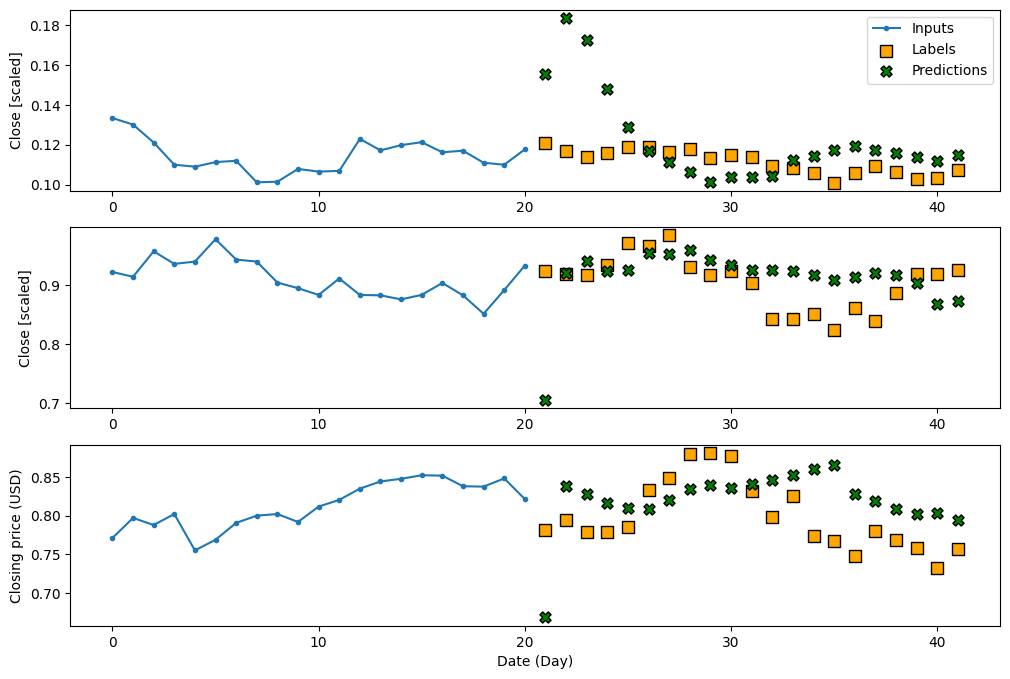

In [58]:
multi_window.plot(lstm)

In [62]:
# CNN : kernel length 3

Kernel_Width = 3
Label_Width = 21
Input_Width = Label_Width + Kernel_Width - 1

In [63]:
cnn_multi_window = DataWindow(input_width=Input_Width, label_width=Label_Width, shift=21, label_columns=['Close'])

In [65]:
# input through Conv1D layer , then into dense (32) layer

cnn = Sequential([
    Conv1D(32, activation='relu', kernel_size=(Kernel_Width)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn, cnn_multi_window)
val_performance['CNN'] = cnn.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
92/92 [==============================] - 4s 8ms/step - loss: 0.0479 - mean_absolute_error: 0.1389 - val_loss: 0.0049 - val_mean_absolute_error: 0.0532
Epoch 2/50
92/92 [==============================] - 1s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0444 - val_loss: 0.0055 - val_mean_absolute_error: 0.0542
Epoch 3/50
92/92 [==============================] - 1s 5ms/step - loss: 0.0034 - mean_absolute_error: 0.0425 - val_loss: 0.0068 - val_mean_absolute_error: 0.0614
Epoch 4/50
26/26 [==============================] - 0s 5ms/step - loss: 0.0063 - mean_absolute_error: 0.0604


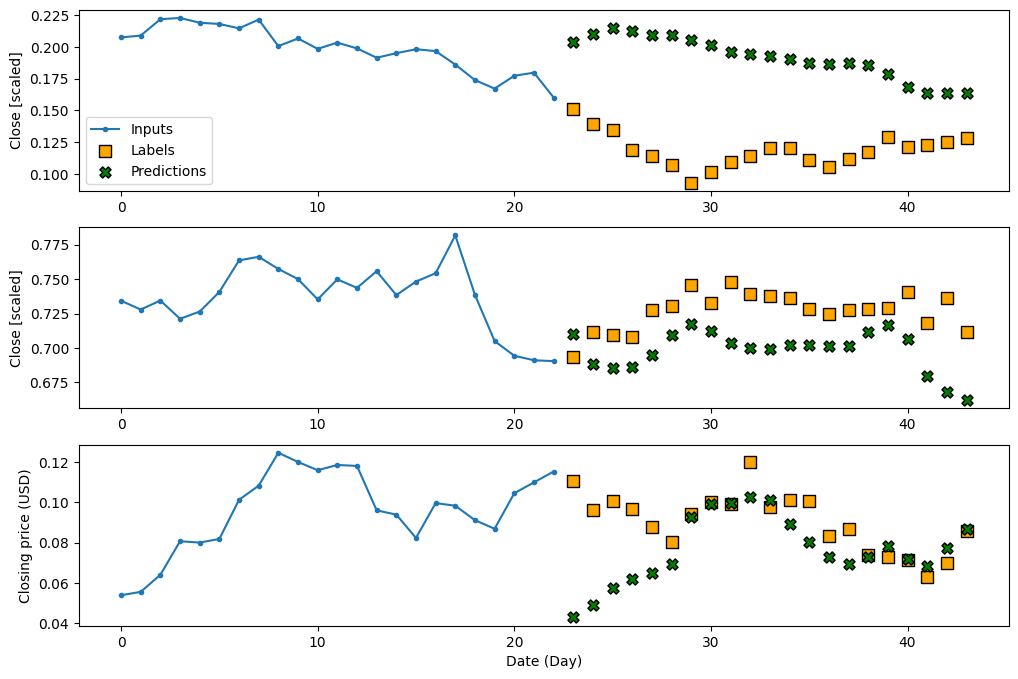

In [66]:
cnn_multi_window.plot(cnn)

In [70]:
# combine CNN and LSTM

cnn_lstm = Sequential([
    Conv1D(32, activation='relu', kernel_size=(Kernel_Width)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

In [72]:
history = compile_and_fit(cnn_lstm, cnn_multi_window)
val_performance['CNN + LSTM'] = cnn_lstm.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
92/92 [==============================] - 6s 34ms/step - loss: 0.0031 - mean_absolute_error: 0.0411 - val_loss: 0.0139 - val_mean_absolute_error: 0.0961
Epoch 2/50
92/92 [==============================] - 2s 25ms/step - loss: 0.0030 - mean_absolute_error: 0.0403 - val_loss: 0.0122 - val_mean_absolute_error: 0.0883
Epoch 3/50
92/92 [==============================] - 1s 16ms/step - loss: 0.0029 - mean_absolute_error: 0.0396 - val_loss: 0.0152 - val_mean_absolute_error: 0.0992
Epoch 4/50
92/92 [==============================] - 2s 17ms/step - loss: 0.0029 - mean_absolute_error: 0.0396 - val_loss: 0.0168 - val_mean_absolute_error: 0.1051
Epoch 5/50
92/92 [==============================] - 2s 16ms/step - loss: 0.0029 - mean_absolute_error: 0.0399 - val_loss: 0.0121 - val_mean_absolute_error: 0.0861
Epoch 6/50
92/92 [==============================] - 2s 16ms/step - loss: 0.0029 - mean_absolute_error: 0.0394 - val_loss: 0.0155 - val_mean_absolute_error: 0.0993
Epoch 7/50
92/92 [====

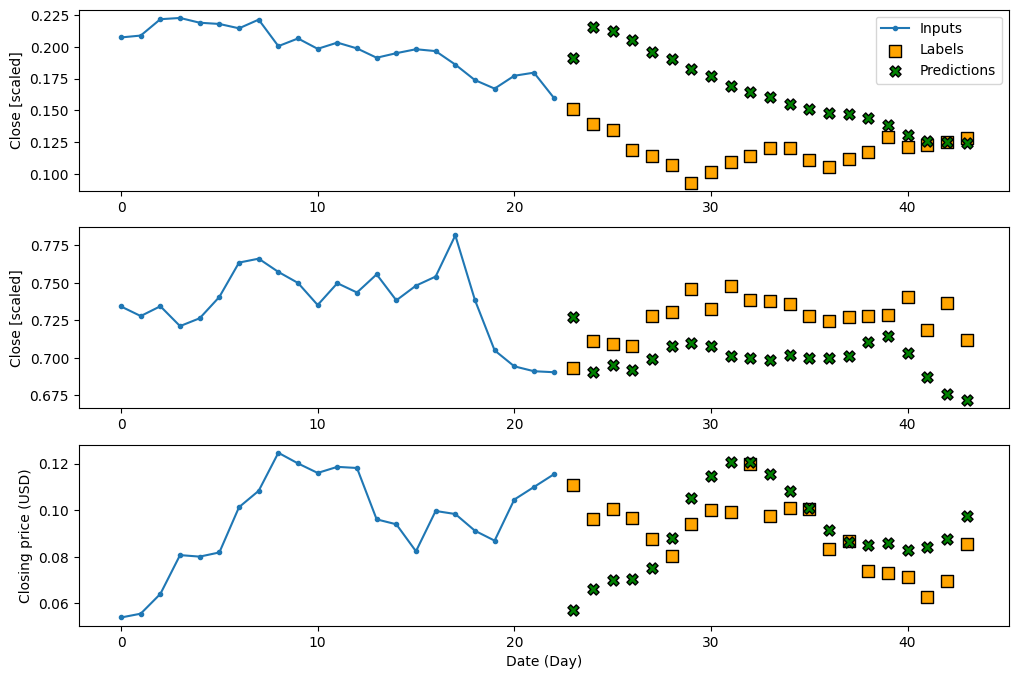

In [73]:
cnn_multi_window.plot(cnn_lstm)

In [79]:
# Autoregressive LSTM : from predictions, generate more predictions

class AutoRegressive(Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = LSTMCell(units)
    self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
    self.dense = Dense(train_df.shape[1])

  def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)
    prediction = self.dense(x)

    return prediction, state

  def call(self, inputs, training=None):
    predictions = []
    prediction, state = self.warmup(inputs)

    predictions.append(prediction)

    for n in range(1, self.out_steps):
      x = prediction
      x, state = self.lstm_cell(x, states=state, training=training)

      prediction = self.dense(x)
      predictions.append(prediction)

    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1,0,2])

    return predictions

In [80]:
Auto_LSTM = AutoRegressive(units=32, out_steps=21)

In [81]:
history = compile_and_fit(Auto_LSTM, multi_window)

val_performance['AutoRegressiveLSTM'] = Auto_LSTM.evaluate(multi_window.val)
performance['AutoRegressiveLSTM'] = Auto_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 16s 45ms/step - loss: 0.0609 - mean_absolute_error: 0.1554 - val_loss: 0.0092 - val_mean_absolute_error: 0.0738
Epoch 2/50
93/93 [==============================] - 2s 18ms/step - loss: 0.0033 - mean_absolute_error: 0.0434 - val_loss: 0.0050 - val_mean_absolute_error: 0.0523
Epoch 3/50
93/93 [==============================] - 2s 19ms/step - loss: 0.0027 - mean_absolute_error: 0.0386 - val_loss: 0.0056 - val_mean_absolute_error: 0.0563
Epoch 4/50
93/93 [==============================] - 2s 20ms/step - loss: 0.0025 - mean_absolute_error: 0.0367 - val_loss: 0.0073 - val_mean_absolute_error: 0.0661
Epoch 5/50
26/26 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_absolute_error: 0.0565


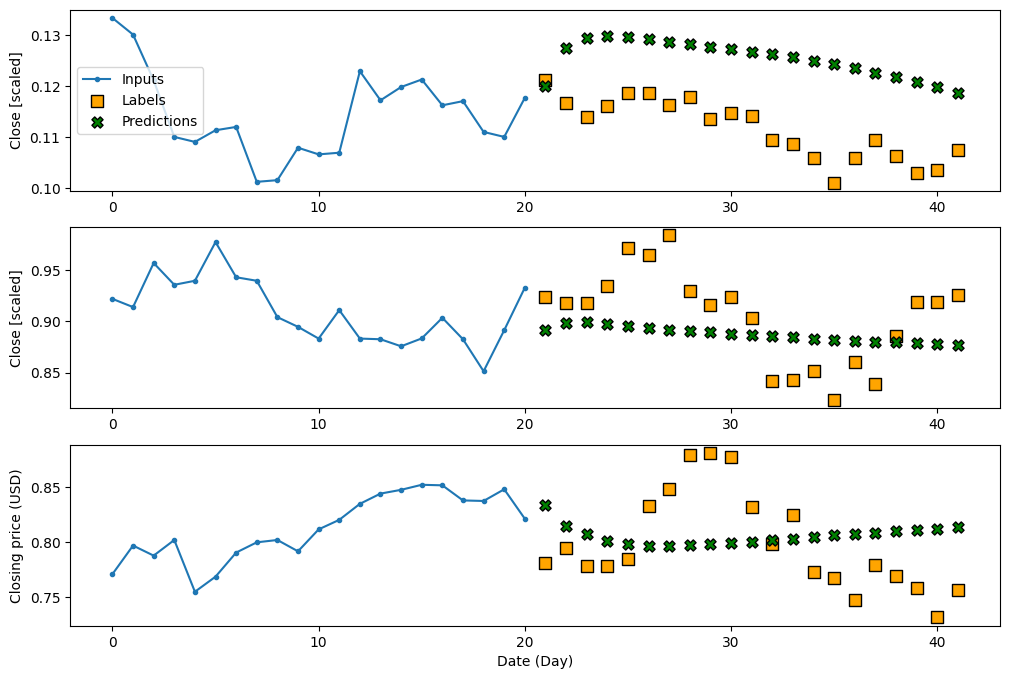

In [82]:
multi_window.plot(Auto_LSTM)

In [83]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

<Figure size 1200x800 with 0 Axes>

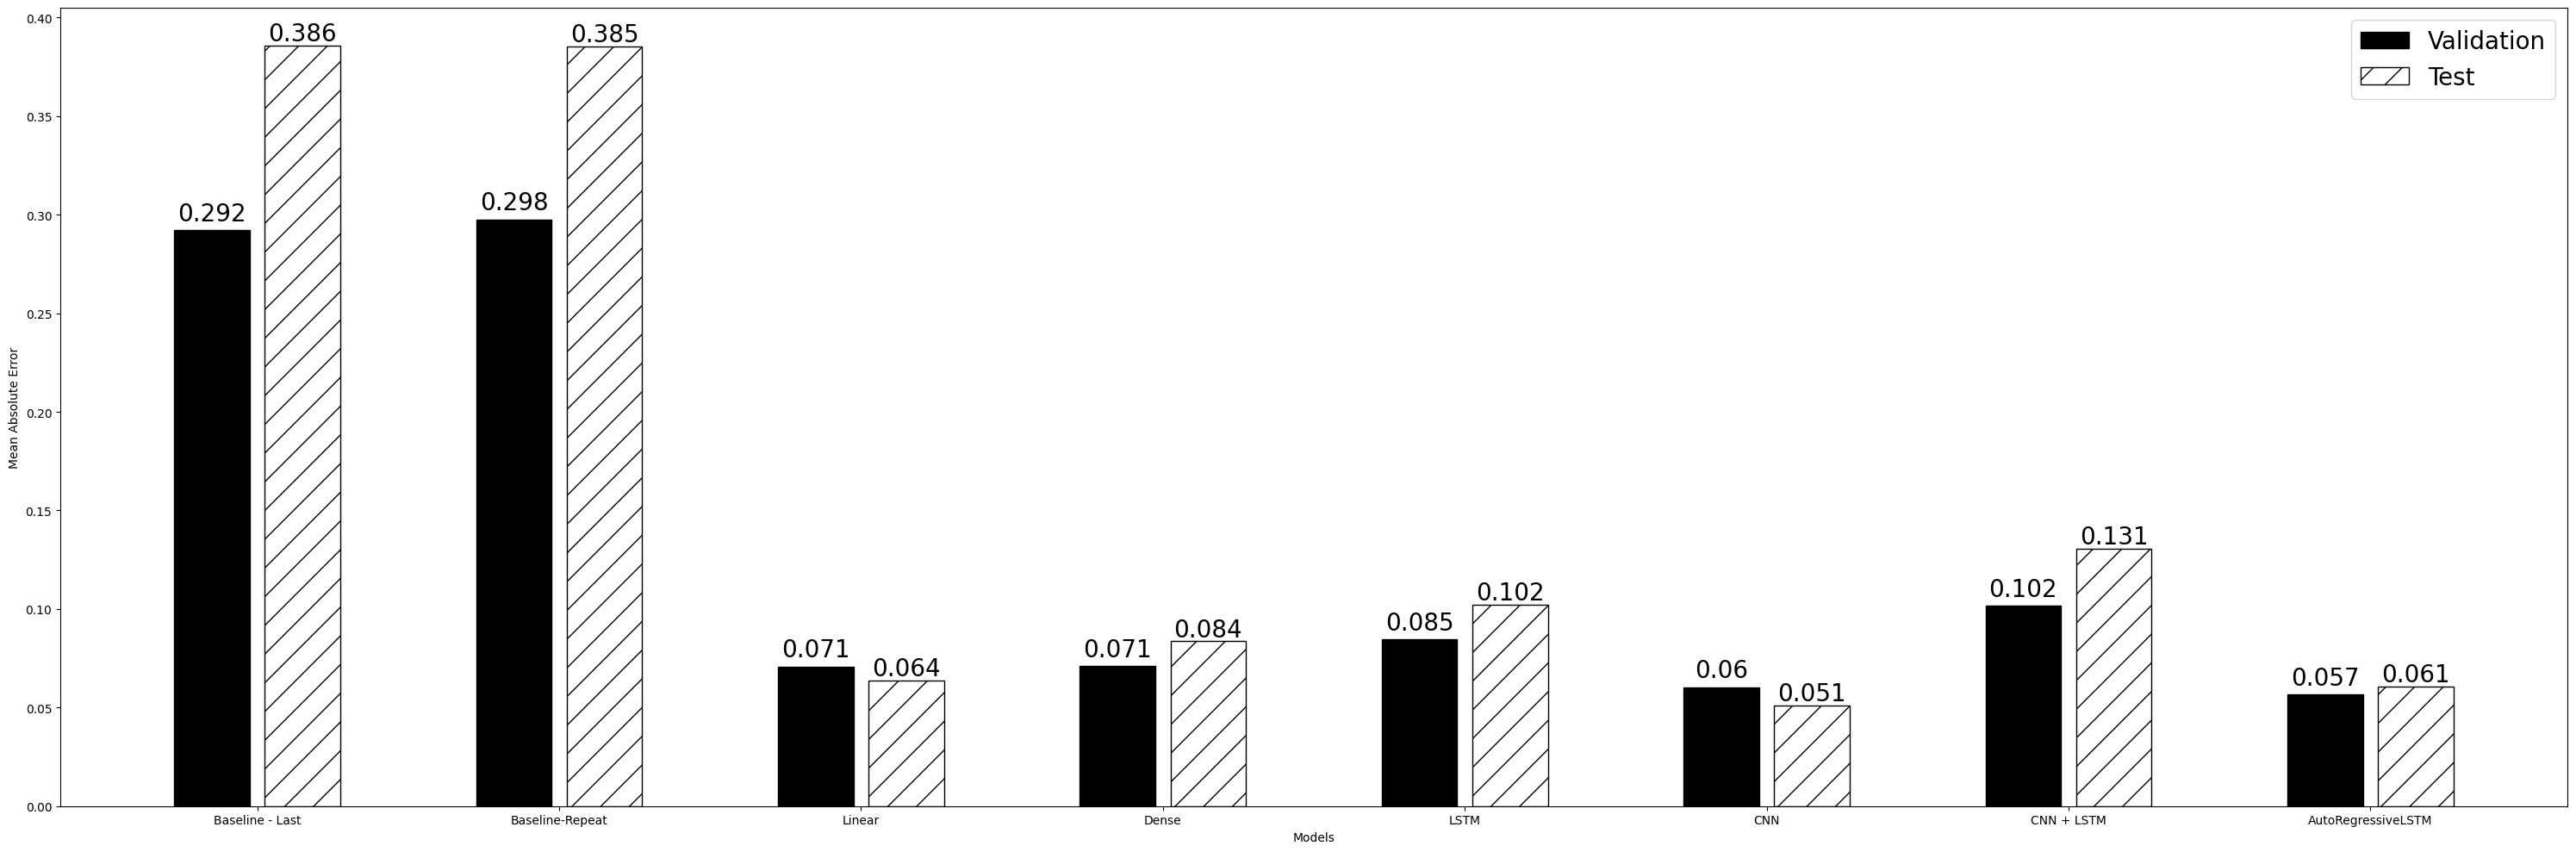

<Figure size 1200x800 with 0 Axes>

In [88]:
x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Models')


font_prop = font_manager.FontProperties(size=20)

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center',fontproperties=font_prop)

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center',fontproperties=font_prop)


plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')

plt.legend(fontsize=20)

plt.tight_layout()
plt.figure(figsize=(12,8))

In [90]:
model_names = ['Baseline-Last', 'Baseline-Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'LSTM+CNN', 'AUTOLSTM']
data = {'Test - MAE': mae_test, 'Validation - MAE': mae_val}
df = pd.DataFrame(data, index=model_names)
df_sorted = df.sort_values(by='Test - MAE', ascending=True)
df_sorted.T

,CNN,AUTOLSTM,Linear,Dense,LSTM,LSTM+CNN,Baseline-Repeat,Baseline-Last
Test - MAE,0.050987,0.060637,0.063719,0.083615,0.102225,0.130567,0.385195,0.385661
Validation - MAE,0.060354,0.056513,0.070842,0.071052,0.084543,0.101610,0.297669,0.292085
